In [1]:
from dataset import Dataset
from utils import parse_args,set_all_seeds,set_output_dir,Logger

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px

In [2]:
data_raw = pd.read_csv("../outputs/explainable/feat_gru_2309.csv")
data = data_raw.pivot_table(index='Entity', columns='Feature', values='Shapley Value').reset_index()
missing_values_per_column = data.isna().sum()
missing_values_per_column[missing_values_per_column > 0]

Feature
Pruned Events    5830
dtype: int64

In [3]:
data

Feature,Entity,.25% Normal Saline_delta,.25% Normal Saline_obs,.25% Normal Saline_value,.45% Normal Saline_delta,.45% Normal Saline_obs,.45% Normal Saline_value,3% Normal Saline_delta,3% Normal Saline_obs,3% Normal Saline_value,...,urine(Foley)_value,urine_ph_delta,urine_ph_obs,urine_ph_value,wbc_delta,wbc_obs,wbc_value,weight_delta,weight_obs,weight_value
0,0.0,0.003298,0.0,0.0,-0.007815,0.0,0.0,0.009222,0.0,0.0,...,0.020787,-0.003564,0.000000,0.000000,0.002705,-0.014324,0.024814,-0.004436,-0.012866,0.071045
1,1.0,0.000000,0.0,0.0,-0.016301,0.0,0.0,-0.008835,0.0,0.0,...,0.078959,-0.008625,0.000000,0.000000,0.000000,-0.005286,0.014856,0.000000,0.000000,0.000000
2,2.0,0.003217,0.0,0.0,-0.009230,0.0,0.0,0.008147,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.007308,-0.001773,0.000801,0.000000,0.000000,0.000000
3,3.0,-0.003504,0.0,0.0,-0.015587,0.0,0.0,-0.002298,0.0,0.0,...,0.070185,0.073651,-0.011703,-0.019528,0.003638,-0.013432,0.005519,0.016824,0.000000,0.000000
4,4.0,0.003951,0.0,0.0,-0.013378,0.0,0.0,-0.013510,0.0,0.0,...,-0.036620,-0.025687,0.000000,-0.014782,-0.008785,-0.022602,0.019001,-0.013055,-0.009758,0.055406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5833,5833.0,-0.012350,0.0,0.0,-0.011591,0.0,0.0,-0.010926,0.0,0.0,...,-0.064745,-0.030040,0.005287,-0.013322,0.009962,-0.019407,0.083129,0.015014,0.000000,0.000000
5834,5834.0,-0.001569,0.0,0.0,-0.027086,0.0,0.0,0.006503,0.0,0.0,...,0.000000,0.010650,0.000000,0.000000,0.000000,-0.012679,-0.014686,0.000000,0.000000,0.000000
5835,5835.0,0.000000,0.0,0.0,-0.014341,0.0,0.0,-0.009813,0.0,0.0,...,0.034643,-0.025962,0.003804,-0.006938,-0.009071,-0.023947,0.025685,-0.028934,-0.005988,0.061025
5836,5836.0,0.000826,0.0,0.0,-0.019420,0.0,0.0,0.004000,0.0,0.0,...,0.000000,0.061675,0.002185,0.000927,0.000000,0.000000,-0.063405,-0.003433,0.000000,0.000000


In [4]:
parser = parse_args(model_type = 'gru', hid_dim =32,dropout = 0.1, lr = 0.001, max_epochs = 70, gradient_accumulation_steps = 8)
args, _ = parser.parse_known_args()
set_all_seeds(args.seed+int(args.run.split('o')[0]))
set_output_dir(args)
args.logger = Logger(args.output_dir, 'log.txt')
args.logger.write('\n'+str(args))
dataset = Dataset(args)


23/09/2024 17:04:38 >> Namespace(dataset='mimic_iii', train_frac=0.7, run='1o10', model_type='gru', max_obs=880, hid_dim=32, num_layers=2, num_heads=4, dropout=0.1, attention_dropout=0.2, kernel_size=4, r=24, M=12, max_timesteps=880, num_ts_feat=51, num_demo_feat=3, hours_look_ahead=24, ref_points=24, pretrain=0, output_dir='../outputs/mimic_iii/gru,hid_dim:32,dropout:0.1,lr:0.001,gradient_accumulation_steps:8,max_epochs:70|train_frac:0.7|run:1o10', output_dir_prefix='', seed=2024, max_epochs=70, patience=10, lr=0.001, train_batch_size=16, gradient_accumulation_steps=8, eval_batch_size=16, print_train_loss_every=100, validate_after=-1, validate_every=None, load_ckpt_path=None, logger=<utils.Logger object at 0x1071729e0>)

23/09/2024 17:04:40 >> Preparing dataset mimic_iii
23/09/2024 17:04:40 >> Removing variables not in training set: ['.3% normal Saline']
23/09/2024 17:04:40 >> # train, val, test TS: [3918, 1120, 800]
23/09/2024 17:04:41 >> pos class weight: 3.934508816120907
23/09/20

12199it [00:00, 1073209.05it/s]


23/09/2024 17:04:41 >> # intervals: 24


941654it [00:00, 1575855.17it/s]


In [5]:
variable_names = list(dataset.var_to_ind_mapping.keys())

In [6]:
def map_feat_to_original(feat):
    if "_value" in feat:
        return feat[:-6]
    elif "_obs" in feat:
        return feat[:-4]
    elif feat in ["age","gender","height"]:
        return feat
    else:
        return feat[:-6]

data_raw['original_feat'] = data_raw['Feature'].apply(map_feat_to_original)
data_raw.head()


,Random Seed,NSamples,Feature,Shapley Value,Entity,Tolerance,original_feat
0,42,1600,PT_value,0.000000,0.0,0.00001,PT
1,42,1600,PTT_value,0.053310,0.0,0.00001,PTT
2,42,1600,wbc_value,0.024814,0.0,0.00001,wbc
3,42,1600,albumin_value,0.000000,0.0,0.00001,albumin
4,42,1600,bicarbonate_value,-0.132855,0.0,0.00001,bicarbonate


In [7]:
data_raw['original_feat'].unique()

array(['PT', 'PTT', 'wbc', 'albumin', 'bicarbonate', 'bilirubin',
       'Calcium_tot', 'Chloride', 'creatinine_blood', 'Magnesium',
       'Potassium', 'BUN', 'Hemoglobin', 'platelet_count', 'rr',
       'temperature', 'weight', 'hr', 'gcs_eye', 'gcs_motor',
       'gcs_verbal', 'D5/.45NS', 'urine_ph', 'urine(Foley)', 'FiO2', 'bg',
       'base_excess', 'CO2_tot', 'Calcium_free', 'lactate',
       'O2_saturation', 'PCO2', 'blood_pd', 'PO2', 'dbp', 'sbp',
       'pre_admission', 'srr', 'Albumin 25%', 'creatinine_urine',
       'Sodium Bicarbonate 8.4%', 'NaCl 3% (Hypertonic Saline)',
       'NaCl 0.45%', 'D5 1/2NS', 'Sodium Bicarbonate',
       '.45% Normal Saline', 'Sodium Bicarbonate 8.4% (Amp)', 'Mannitol',
       '3% Normal Saline', 'NaCl 23.4%', '.25% Normal Saline', 'age',
       'gender', 'height', 'Pruned '], dtype=object)

In [8]:
shap_per_original = data_raw.groupby(["original_feat","Entity"]).agg({"Shapley Value":["sum"]}).reset_index()
shap_per_original.columns = ["original_feat_name","entity","shapley_value"]
shap_per_original

,original_feat_name,entity,shapley_value
0,.25% Normal Saline,0.0,0.003298
1,.25% Normal Saline,1.0,0.000000
2,.25% Normal Saline,2.0,0.003217
3,.25% Normal Saline,3.0,-0.003504
4,.25% Normal Saline,4.0,0.003951
...,...,...,...
315255,weight,5833.0,0.015014
315256,weight,5834.0,0.000000
315257,weight,5835.0,0.026103
315258,weight,5836.0,-0.003433


In [11]:
data_feat_original = shap_per_original.groupby("original_feat_name").agg({"shapley_value":["mean","std"]}).sort_values(('shapley_value', 'mean')).reset_index()
data_feat_original.columns = ["feature","shap_mean","shap_std"]
data_feat_original = data_feat_original.reindex(
    data_feat_original['shap_mean'].abs().sort_values(ascending=False).index
)
top_feat= data_feat_original[data_feat_original['shap_mean'].abs()>0.01]
top_feat.head(10)

,feature,shap_mean,shap_std
54,hr,0.102515,0.097060
0,Hemoglobin,-0.056173,0.053589
1,Potassium,-0.046829,0.028774
2,PO2,-0.044830,0.032185
53,platelet_count,0.038026,0.076952
3,PT,-0.036131,0.032633
4,BUN,-0.035701,0.044103
5,blood_pd,-0.029955,0.033209
6,rr,-0.027553,0.034125
7,lactate,-0.026821,0.039893


In [13]:
print(top_feat.head(10).to_latex(index=False))

\begin{tabular}{lrr}
\toprule
feature & shap_mean & shap_std \\
\midrule
hr & 0.102515 & 0.097060 \\
Hemoglobin & -0.056173 & 0.053589 \\
Potassium & -0.046829 & 0.028774 \\
PO2 & -0.044830 & 0.032185 \\
platelet_count & 0.038026 & 0.076952 \\
PT & -0.036131 & 0.032633 \\
BUN & -0.035701 & 0.044103 \\
blood_pd & -0.029955 & 0.033209 \\
rr & -0.027553 & 0.034125 \\
lactate & -0.026821 & 0.039893 \\
\bottomrule
\end{tabular}



In [14]:
print(data_feat_original.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
feature & shap_mean & shap_std \\
\midrule
hr & 0.102515 & 0.097060 \\
Hemoglobin & -0.056173 & 0.053589 \\
Potassium & -0.046829 & 0.028774 \\
PO2 & -0.044830 & 0.032185 \\
platelet_count & 0.038026 & 0.076952 \\
PT & -0.036131 & 0.032633 \\
BUN & -0.035701 & 0.044103 \\
blood_pd & -0.029955 & 0.033209 \\
rr & -0.027553 & 0.034125 \\
lactate & -0.026821 & 0.039893 \\
urine(Foley) & -0.025088 & 0.055606 \\
Calcium_free & -0.023188 & 0.067645 \\
Mannitol & -0.022527 & 0.018419 \\
gcs_eye & -0.019542 & 0.026028 \\
FiO2 & -0.018449 & 0.042187 \\
pre_admission & -0.017961 & 0.025119 \\
temperature & -0.017779 & 0.042831 \\
Sodium Bicarbonate 8.4% & -0.016981 & 0.029080 \\
NaCl 23.4% & 0.016887 & 0.012665 \\
bg & -0.016309 & 0.034700 \\
Chloride & 0.016182 & 0.086300 \\
creatinine_urine & 0.015949 & 0.025876 \\
wbc & -0.015221 & 0.043093 \\
.45% Normal Saline & -0.013921 & 0.022966 \\
Sodium Bicarbonate 8.4% (Amp) & -0.013446 & 0.013735 \\
CO2_tot & -0.012638 &

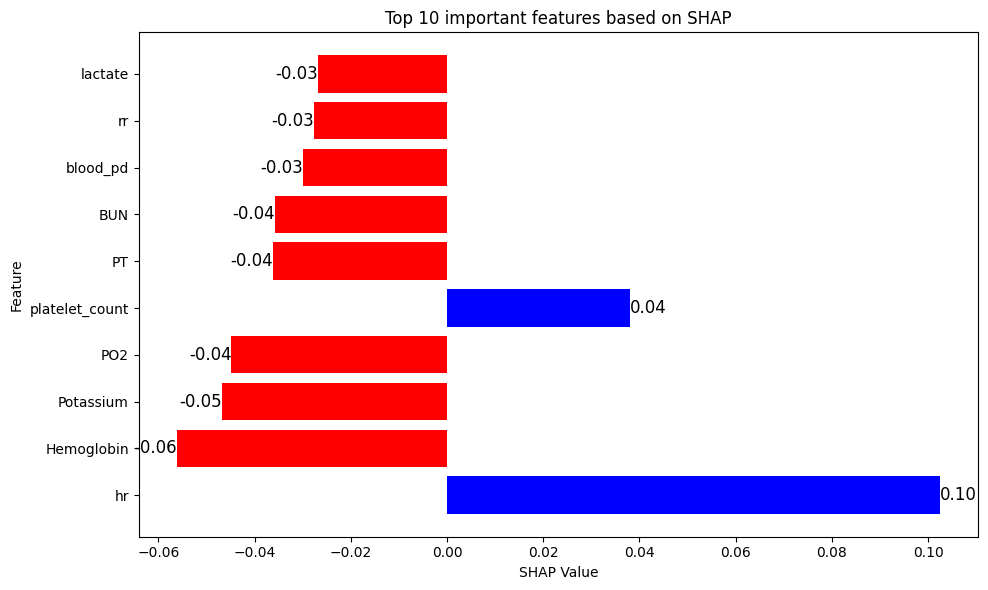

In [16]:
top_10 = top_feat.head(10)
# Define colors: blue for positive and red for negative
colors = ['red' if val < 0 else 'blue' for val in top_10['shap_mean']]

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10['feature'], top_10['shap_mean'], color=colors)

# Add labels and title
plt.xlabel('SHAP Value')
plt.ylabel('Feature')
plt.title('Top 10 important features based on SHAP')

# Annotate the bars with SHAP values
for bar in bars:
    plt.text(
        bar.get_width(),  # X-coordinate of the text
        bar.get_y() + bar.get_height() / 2,  # Y-coordinate of the text (centered on the bar)
        f'{bar.get_width():.2f}',  # The SHAP value rounded to 2 decimal places
        va='center',  # Vertical alignment of the text
        ha='right' if bar.get_width() < 0 else 'left',  # Horizontal alignment (left for positive, right for negative)
        color='black',  # Text color
        fontsize=12  # Text font size
    )

# Show the plot
plt.tight_layout()
plt.show()

/var/folders/vl/d9d_7_5973n6yds7k19rktmw0000gn/T/ipykernel_85424/797278644.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='shapley_value', y='original_feat_name', data=top_feat_per_entity, palette='coolwarm')


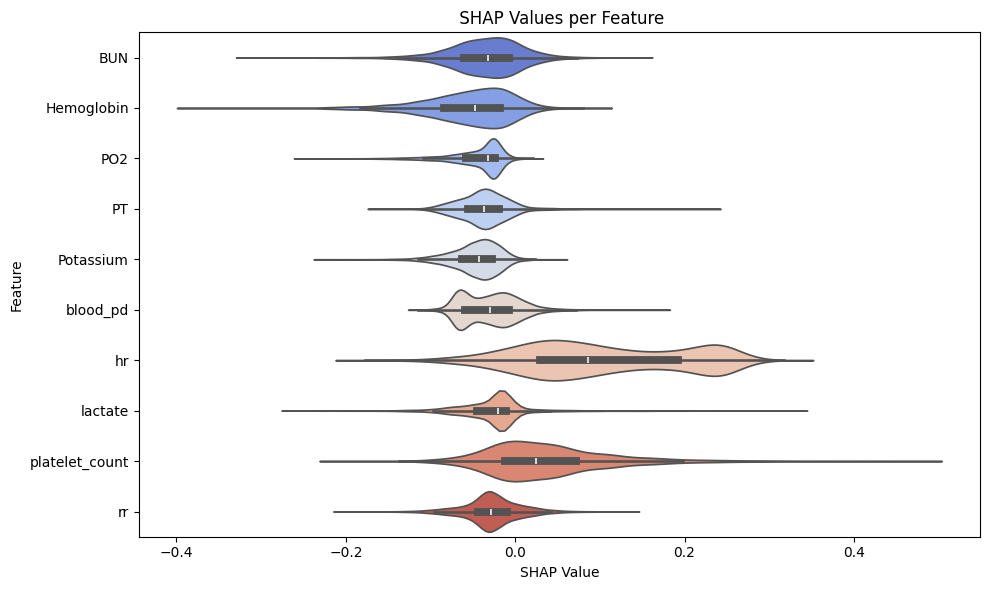

In [17]:
import seaborn as sns

top_feat_names = list(top_10['feature'].unique())
top_feat_per_entity = shap_per_original[shap_per_original['original_feat_name'].isin(top_feat_names)]

# Create a beeswarm plot using swarmplot
plt.figure(figsize=(10, 6))
sns.violinplot(x='shapley_value', y='original_feat_name', data=top_feat_per_entity, palette='coolwarm')

# Add labels and title
plt.xlabel('SHAP Value')
plt.ylabel('Feature')
plt.title(' SHAP Values per Feature')

# Show the plot
plt.tight_layout()
plt.show()

## Statistics

In [14]:
top_feat_per_entity

,original_feat_name,entity,shapley_value
4170,CO2_tot,0.0,-0.006483
4171,CO2_tot,1.0,0.015019
4172,CO2_tot,2.0,0.020580
4173,CO2_tot,3.0,0.026353
4174,CO2_tot,4.0,-0.006445
...,...,...,...
40027,sbp,829.0,-0.064199
40028,sbp,830.0,0.013804
40029,sbp,831.0,0.012859
40030,sbp,832.0,-0.032435


In [48]:
def run_kmeans(X_scaled, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_scaled)
    return kmeans

def run_dbscan(X_scaled):
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust eps and min_samples based on your data
    labels = dbscan.fit_predict(X_scaled)
    return labels

def get_mortality_labels():
    return

def plot_pca(X_scaled, labels, clustering_algo_name):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    loadings = pca.components_

    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
    plt.title('PCA Visualization of {}'.format(clustering_algo_name))
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

    return loadings

def plot_tsne(X_scaled, labels, perplexity, clustering_algo_name):
    for p in perplexity:
        tsne = TSNE(n_components=2, random_state=42, perplexity=p)
        X_tsne = tsne.fit_transform(X_scaled)
        # Plot the t-SNE result with clusters
        plt.figure(figsize=(8, 6))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50)
        plt.title('t-SNE (perplexity ={}) Visualization of {}'.format(str(p),clustering_algo_name))
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.colorbar(label='Cluster')
        plt.show()


def plot_umap(X_scaled,labels,clustering_algo_name):
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X)

    # Plot the UMAP result
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='Spectral', s=10)

    plt.title('UMAP Visualization of {}'.format(clustering_algo_name))
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar(scatter)
    plt.show()

In [20]:
top_feat_per_entity_pivoted = top_feat_per_entity.pivot_table(index='entity', columns='original_feat_name', values='shapley_value').reset_index()

In [21]:
X = top_feat_per_entity_pivoted.drop('entity', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
dbscan_all = run_dbscan(X_scaled)
dbscan_all

array([-1, -1, -1, ..., -1, -1, -1])

Number of clusters 2


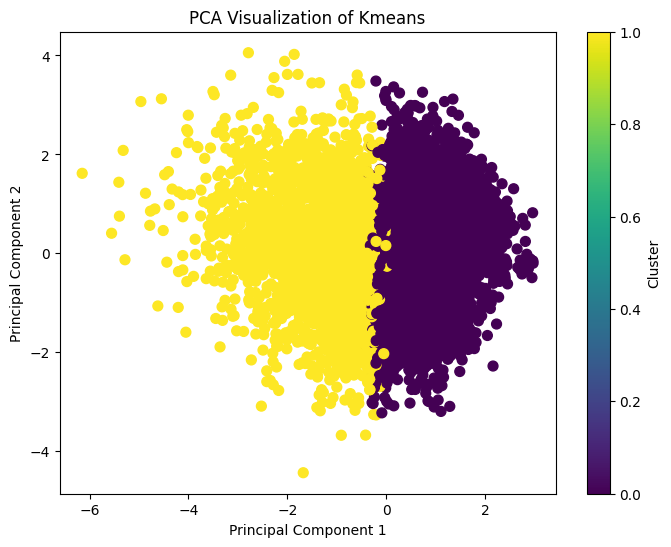

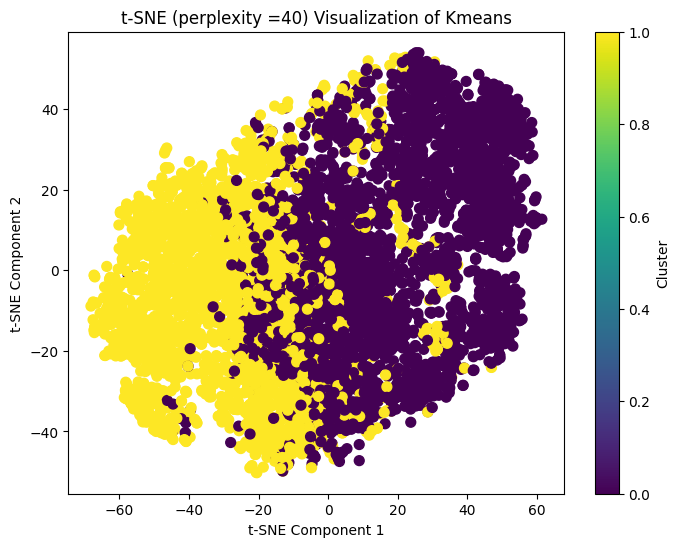

/Users/zhiwenxu/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


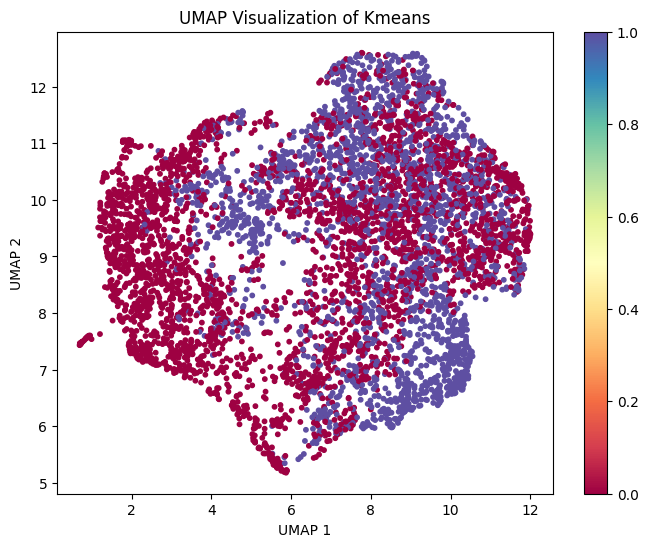

Number of clusters 3


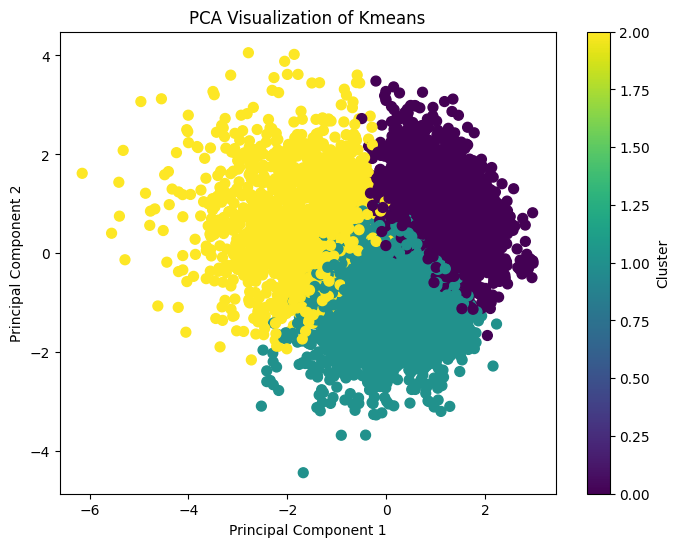

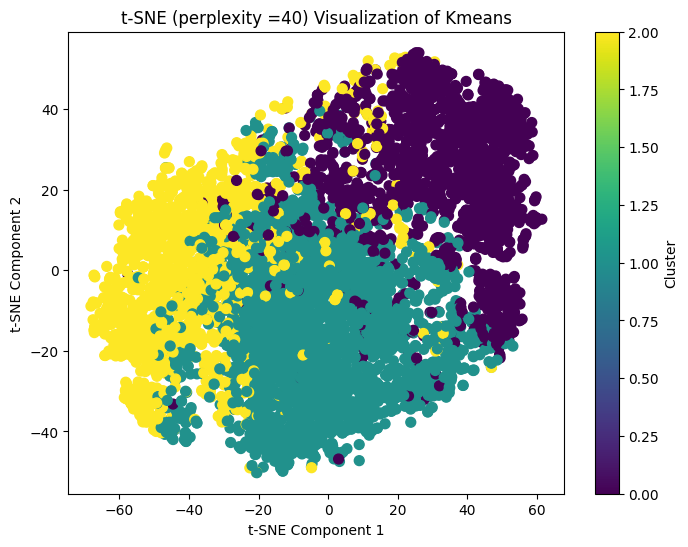

/Users/zhiwenxu/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


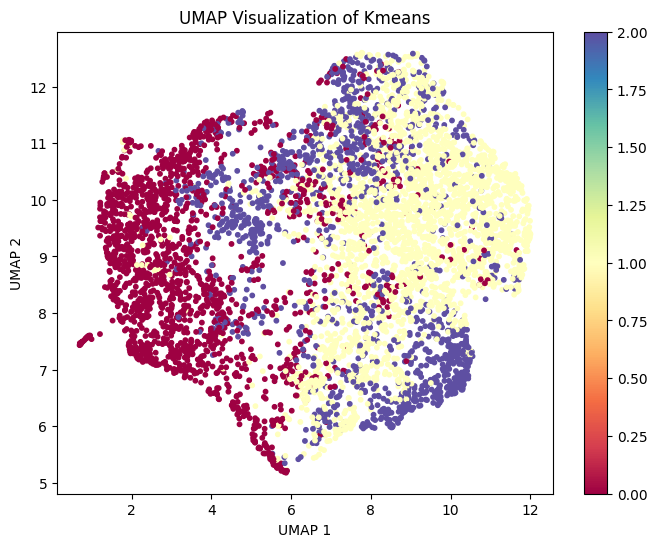

Number of clusters 4


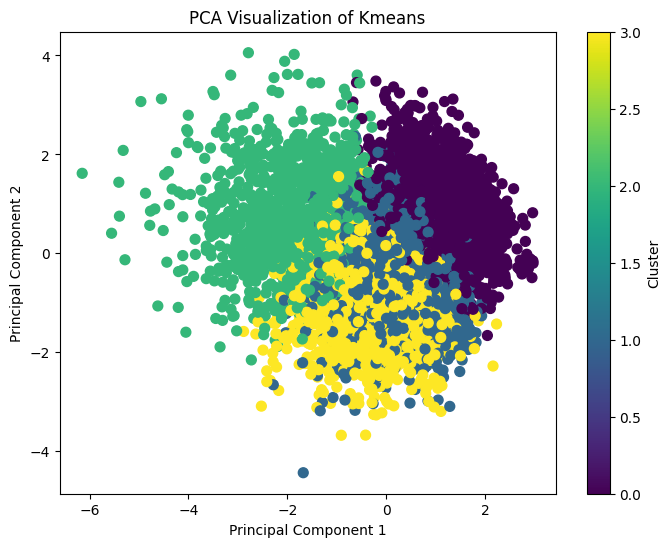

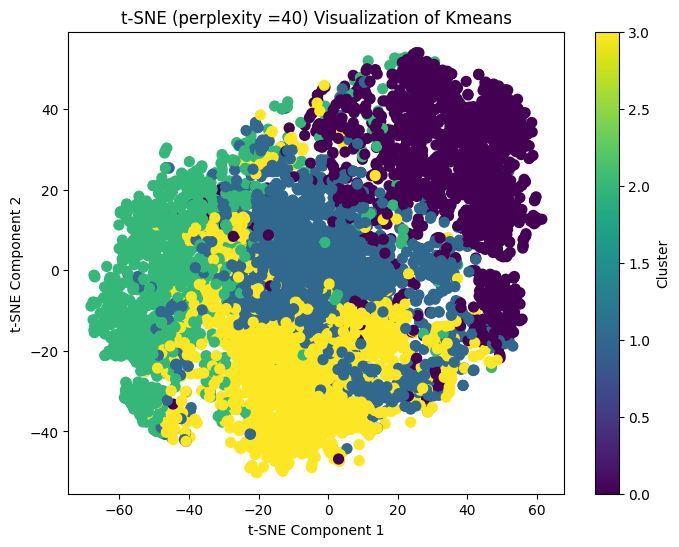

/Users/zhiwenxu/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


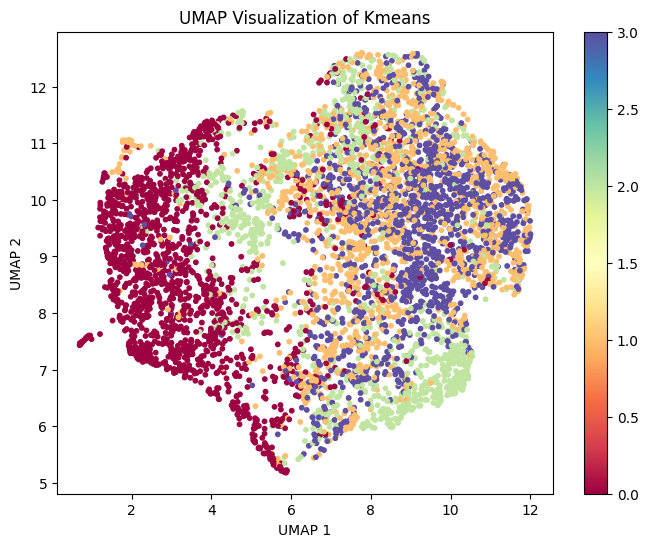

In [24]:
X = top_feat_per_entity_pivoted.drop('entity', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
for num_cluster in [2,3,4]:
    print("Number of clusters {}".format(str(num_cluster)))
    kmeans_all = run_kmeans(X_scaled,num_cluster)
    dbscan_all = run_dbscan(X_scaled)
    #for kmeans
    plot_pca(X_scaled,kmeans_all.labels_,"Kmeans")
    plot_tsne(X_scaled,kmeans_all.labels_,[40],"Kmeans")
    plot_umap(X_scaled,kmeans_all.labels_,"Kmeans")

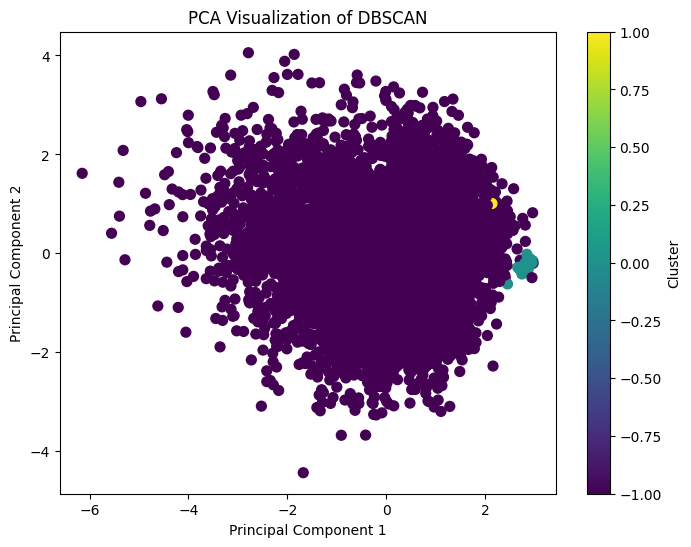

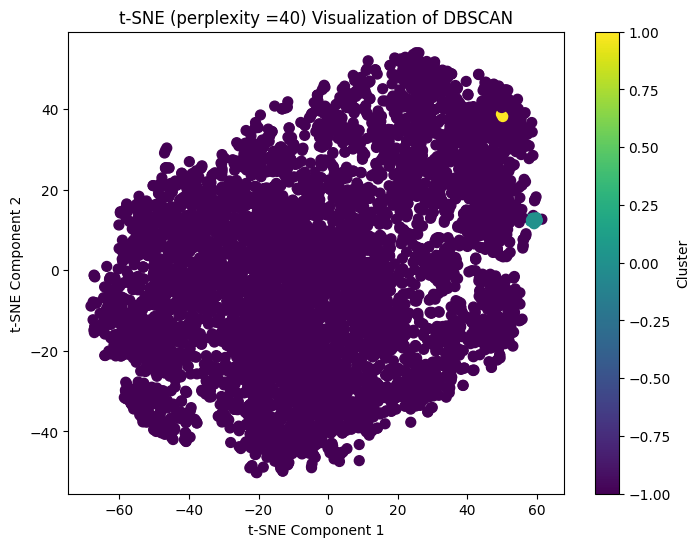

/Users/zhiwenxu/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


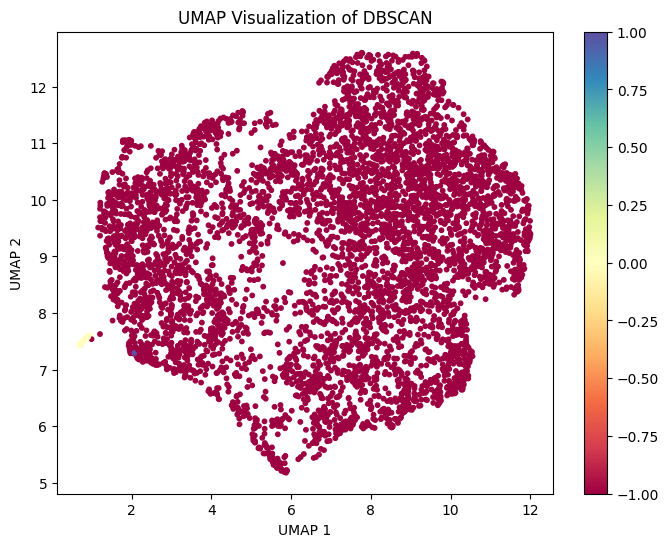

In [33]:
dbscan_all = run_dbscan(X_scaled)
plot_pca(X_scaled,dbscan_all,"DBSCAN")
plot_tsne(X_scaled,dbscan_all,[40],"DBSCAN")
plot_umap(X_scaled,dbscan_all,"DBSCAN")

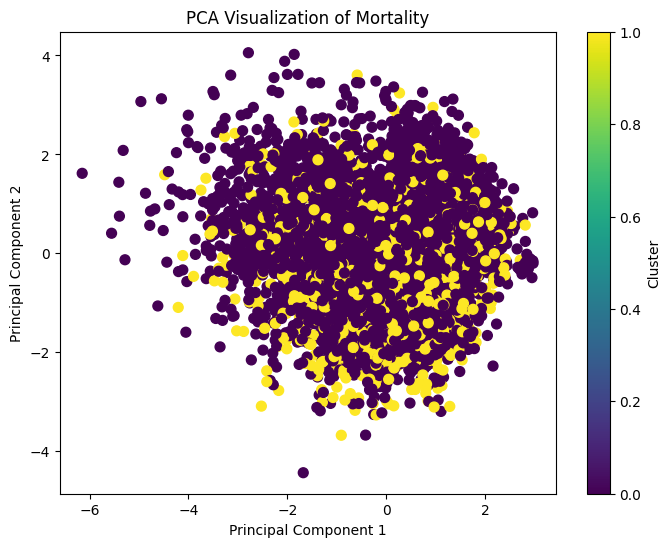

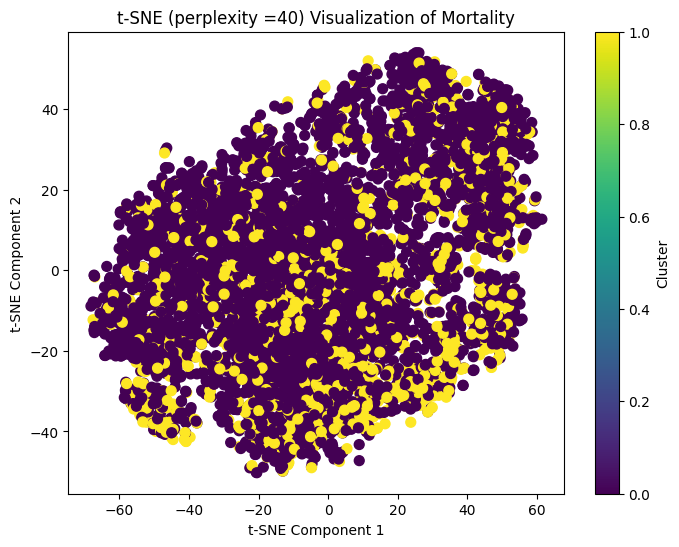

/Users/zhiwenxu/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


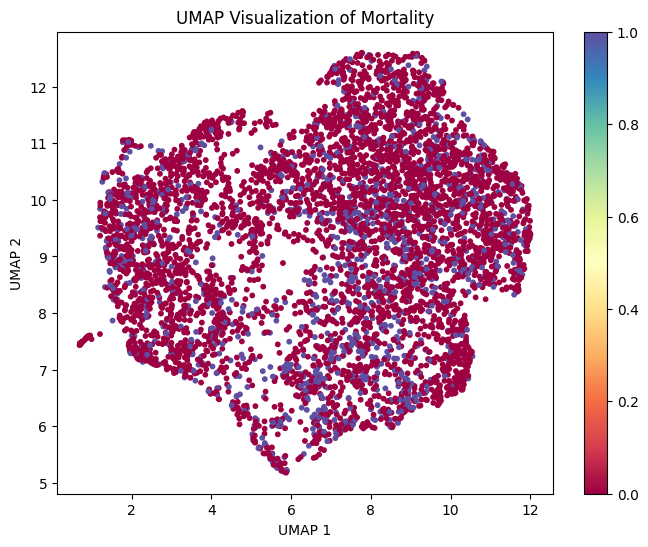

In [32]:
mortality_labels = dataset.y
#for kmeans
plot_pca(X_scaled,mortality_labels,"Mortality")
plot_tsne(X_scaled,mortality_labels,[40],"Mortality")
plot_umap(X_scaled,mortality_labels,"Mortality")

In [46]:
#sample 0: survived
#sample 1: died
survived = shap_per_original[shap_per_original['entity']==0]
survived_top_10 = survived.reindex(
    survived['shapley_value'].abs().sort_values(ascending=False).index
).head(10)
print(survived_top_10.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
original_feat_name & entity & shapley_value \\
\midrule
Chloride & 0.000000 & 0.261911 \\
bicarbonate & 0.000000 & -0.135307 \\
BUN & 0.000000 & -0.123263 \\
hr & 0.000000 & 0.103923 \\
gcs_verbal & 0.000000 & -0.097848 \\
base_excess & 0.000000 & 0.093577 \\
Calcium_free & 0.000000 & -0.082617 \\
Potassium & 0.000000 & -0.077042 \\
lactate & 0.000000 & -0.073895 \\
Hemoglobin & 0.000000 & -0.071622 \\
\bottomrule
\end{tabular}



In [47]:
died = shap_per_original[shap_per_original['entity']==1]
died_top_10 = died.reindex(
    died['shapley_value'].abs().sort_values(ascending=False).index
).head(10)
died_top_10
print(died_top_10.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
original_feat_name & entity & shapley_value \\
\midrule
bilirubin & 1.000000 & 0.136582 \\
age & 1.000000 & -0.119554 \\
platelet_count & 1.000000 & 0.088250 \\
Calcium_tot & 1.000000 & 0.085804 \\
Calcium_free & 1.000000 & -0.077181 \\
gcs_motor & 1.000000 & -0.068237 \\
D5/.45NS & 1.000000 & -0.057224 \\
urine(Foley) & 1.000000 & 0.053208 \\
Chloride & 1.000000 & 0.051410 \\
gcs_verbal & 1.000000 & 0.050837 \\
\bottomrule
\end{tabular}



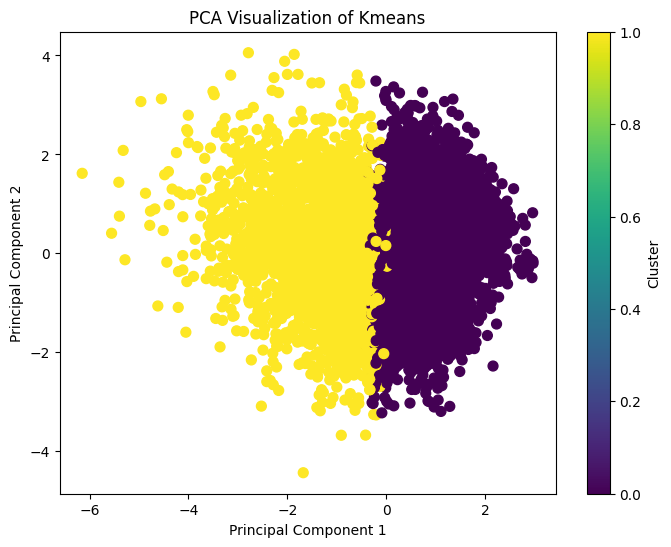

\begin{tabular}{lr}
\toprule
Feature & PC1_Loading \\
\midrule
PO2 & 0.542449 \\
Potassium & 0.509132 \\
blood_pd & -0.475076 \\
hr & 0.319788 \\
Hemoglobin & 0.313325 \\
lactate & -0.101636 \\
rr & -0.072166 \\
BUN & 0.054616 \\
PT & -0.042817 \\
platelet_count & 0.006762 \\
\bottomrule
\end{tabular}



In [54]:
kmeans_all = run_kmeans(X_scaled,2)
loadings = plot_pca(X_scaled,kmeans_all.labels_,"Kmeans")
pc1_loadings = loadings[0]
pc1_loadings_df = pd.DataFrame({
'Feature': X.columns,
'PC1_Loading': pc1_loadings
})
pc1_loadings_df = pc1_loadings_df.reindex(
    pc1_loadings_df['PC1_Loading'].abs().sort_values(ascending=False).index
)
print(pc1_loadings_df.to_latex(index=False))